# Training a two layer model with a reservoir for the generation of coherent state

Model with two trainable complex layers and one untrainable random reservoir 

Use the derivative for the training

NOTE: remember to shut down the kernel when out of memory

Bug train model:

<img src="../img/twolayersreservoir.png" width="900" height="200" />

<img src="../img/logo_circular.png" width="20" height="20" />@by claudio<br>

nonlinearxwaves@gmail.com<br>
@created 24 sep 2020<br>
@version 15 may 2023

In [1]:
import numpy as np
from scipy.linalg import expm, sinm, cosm
from thqml import phasespace as ps
from thqml.utilities import utilities
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

2023-05-14 11:16:31.169818: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-14 11:16:31.169841: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float32

Precision for output on the screen

In [3]:
np.set_printoptions(precision=2)

## Dimension

In [4]:
N = 10

## Build vacuum by the Gaussian state

In [5]:
vacuum = ps.VacuumLayer(N)

2023-05-14 11:16:33.445857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-14 11:16:33.445895: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-14 11:16:33.445919: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x1): /proc/driver/nvidia/version does not exist
2023-05-14 11:16:33.446214: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Build the pullback layer for generating the input coherent state

### Target displacement vector 
The displacement vector is a normalized column vector

In [6]:
dinput = 3.0*np.ones((N,1)); 
norm = np.linalg.norm(dinput)
dinput = dinput /norm
print(dinput.transpose())

[[0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32]]


Check the normalization of the dtarget

In [7]:
print(np.dot(dinput.transpose(), dinput)) 

[[1.]]


### Build the displacement layer
The layer is a constant layer, as no training is needed

In [8]:
D = ps.DisplacementLayerConstant(dinput)

## Define the layer for the complex medium
The LinearConstantMultiHead generate by default a random medium with 
the relevant symplectic operator

In [9]:
R = ps.RandomLayerConstant(N)

## Define the trainable unitary layer in input

In [10]:
Ci = ps.RandomLayer(N)

## Define the trainable unitary layer in output

In [11]:
Co = ps.RandomLayer(N)

## Define the normalize target displacement vector 
Can be any normalized column vector

In [12]:
dtarget = np.zeros((N,1)); dtarget[0]=1.0; dtarget[1]=2.0; dtarget[2]=2.0;
norm = np.linalg.norm(dtarget)
dtarget = dtarget /norm
print(dtarget.transpose())

[[0.33 0.67 0.67 0.   0.   0.   0.   0.   0.   0.  ]]


## Connect the layers

In [13]:
xin = tf.keras.layers.Input(N);print(xin) # input layer
x4, a4 = Co(xin) # output trainable layer
x3, a3 = R(x4, a4) # reservoir layer (untrainable)
x2, a2 = Ci(x3,a3) # input trainable layer
x1, a1 = D(x2,a2) # linear layer to generate the input coherent state 
chir, chii = vacuum(x1, a1)  # vacuum
pullback = tf.keras.Model(inputs = xin, outputs=[chir, chii])
# Add the derivative layer for training
der_layer = ps.avgR(N)
Re = der_layer(chir,chii, pullback)
pullback_der = tf.keras.Model(inputs = xin, outputs=Re)

KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


### Store the M,d of the Random layer for later chek

In [14]:
M_R, _ = R.get_M();

In [15]:
M_R_random=M_R.numpy()

In [16]:
d_R_random=R.d.numpy()

### Store the M, d of the untrained U_train layer for later check

In [17]:
WR_untrained_Ci = Ci.WR.numpy()

In [18]:
WI_untrained_Ci = Ci.WI.numpy()

In [19]:
M_untrained_Ci, MI_untrained_Ci = Ci.get_M()

In [20]:
WR_untrained_Co = Co.WR.numpy()

In [21]:
WI_untrained_Co = Co.WI.numpy()

In [22]:
M_untrained_Co, MI_untrained_Co = Co.get_M()

### Auxiliary staff

In [23]:
x0 = tf.constant(np.zeros((1,N)))
with tf.GradientTape() as tape:
    tape.watch(x0)
    cr, ci = pullback(x0)
    chii_x = tape.gradient(ci, x0)

In [24]:
@tf.function
def derivative(yr):
    x = tf.constant(np.zeros((1,N)))
    with tf.GradientTape() as tape:
        tape.watch(x)
        cr, ci = pullback(x)
        chii_x = tape.gradient(ci, x)
    return chii_x

## Build the training set by using a target characteristic function

Number of training points
Also a single training point is enough for Gaussian state, more points improve the training

In [25]:
Nbatch = 100

Define the numpy function for the target characteristic function:
    a coherent state with a target displacement
One need a target d for any training points

In [26]:
xtrain = np.random.rand(Nbatch, N)-0.5
Rtrain = np.zeros((Nbatch,N))
for j in range(Nbatch):
    for i in range(N):
        Rtrain[j,i]=dtarget[i]

## Train the model

In [27]:
pullback_der.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss='mean_squared_error')

Summary of the derivative model

In [28]:
pullback_der.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 random_layer_2 (RandomLayer)   [(None, 10),         50          ['input_1[0][0]']                
                                 (10, 1)]                                                         
                                                                                                  
 random_layer (RandomLayer)     [(None, 10),         50          ['random_layer_2[0][0]',         
                                 (10, 1)]                         'random_layer_2[0][1]']         
                                                                                            

Test the call of the derivative layer

In [29]:
pullback_der(xtrain)

<tf.Tensor: shape=(1, 10), dtype=float64, numpy=
array([[-0.34, -0.48, -0.2 , -0.31, -0.09, -0.26,  0.06, -0.48, -0.39,
        -0.23]])>

## Training of the model

In [30]:
history = pullback_der.fit(x=xtrain,
                      y=Rtrain,
                      epochs=50,
                      verbose=2)

Epoch 1/50
4/4 - 3s - loss: 0.3005 - 3s/epoch - 844ms/step
Epoch 2/50
4/4 - 0s - loss: 0.2270 - 7ms/epoch - 2ms/step
Epoch 3/50
4/4 - 0s - loss: 0.1321 - 9ms/epoch - 2ms/step
Epoch 4/50
4/4 - 0s - loss: 0.0810 - 8ms/epoch - 2ms/step
Epoch 5/50
4/4 - 0s - loss: 0.0792 - 9ms/epoch - 2ms/step
Epoch 6/50
4/4 - 0s - loss: 0.0711 - 8ms/epoch - 2ms/step
Epoch 7/50
4/4 - 0s - loss: 0.0504 - 9ms/epoch - 2ms/step
Epoch 8/50
4/4 - 0s - loss: 0.0357 - 7ms/epoch - 2ms/step
Epoch 9/50
4/4 - 0s - loss: 0.0308 - 8ms/epoch - 2ms/step
Epoch 10/50
4/4 - 0s - loss: 0.0252 - 8ms/epoch - 2ms/step
Epoch 11/50
4/4 - 0s - loss: 0.0180 - 8ms/epoch - 2ms/step
Epoch 12/50
4/4 - 0s - loss: 0.0142 - 7ms/epoch - 2ms/step
Epoch 13/50
4/4 - 0s - loss: 0.0120 - 9ms/epoch - 2ms/step
Epoch 14/50
4/4 - 0s - loss: 0.0089 - 8ms/epoch - 2ms/step
Epoch 15/50
4/4 - 0s - loss: 0.0068 - 7ms/epoch - 2ms/step
Epoch 16/50
4/4 - 0s - loss: 0.0055 - 10ms/epoch - 2ms/step
Epoch 17/50
4/4 - 0s - loss: 0.0040 - 8ms/epoch - 2ms/step
Epoc

Text(0.5, 0, 'Epoch')

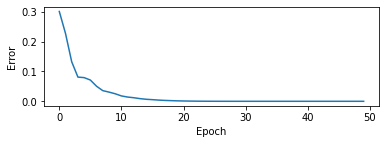

In [31]:
# %%
# %matplotlib inline
# Plot training & validation accuracy values
f1 = plt.figure
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.ylabel('Error')
plt.xlabel('Epoch')

## Test the derivative of the model
Evaluate the expectation value of the displacement as derivative of the characterisc function

In [32]:
x = tf.Variable(np.zeros((1,N)), dtype=tf_real) # the derivative are evaluated at x=0
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    chir, chii = pullback(x)

In [33]:
print(tape.gradient(chir,x))

tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)


In [34]:
print(tape.gradient(chii,x))

tf.Tensor(
[[ 3.33e-01  6.67e-01  6.67e-01  2.93e-05 -8.02e-06  2.59e-05  2.46e-05
   5.53e-05  2.13e-05  3.32e-05]], shape=(1, 10), dtype=float32)


Use the derivative function for the derivative

In [35]:
print(derivative(x))

tf.Tensor(
[[ 3.33e-01  6.67e-01  6.67e-01  2.93e-05 -7.99e-06  2.60e-05  2.45e-05
   5.53e-05  2.13e-05  3.31e-05]], shape=(1, 10), dtype=float64)


Use the derivative model

In [36]:
pullback_der(xtrain)

<tf.Tensor: shape=(1, 10), dtype=float64, numpy=
array([[ 3.33e-01,  6.67e-01,  6.67e-01,  2.93e-05, -8.02e-06,  2.59e-05,
         2.46e-05,  5.53e-05,  2.13e-05,  3.32e-05]])>

## Plot the model

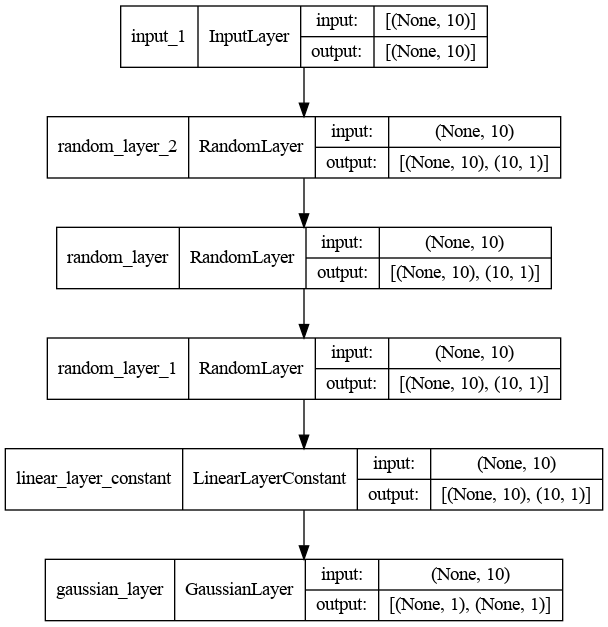

In [37]:
dot_img_file = 'pullback_twolayers_DER.png'
tf.keras.utils.plot_model(pullback, to_file=dot_img_file, show_shapes=True)

## Check the weights of the layers

### d and M of the complex layer R(these are unchanged)

In [38]:
print(R.d.numpy().transpose())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [39]:
print(d_R_random.transpose())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [40]:
M_Random_trained, _ =R.get_M(); print(M_Random_trained.numpy())

[[ 0.59  0.46  0.13  0.07 -0.37  0.   -0.42  0.04 -0.03  0.32]
 [-0.46  0.59 -0.07  0.13 -0.   -0.37 -0.04 -0.42 -0.32 -0.03]
 [-0.12 -0.1   0.49  0.61  0.25  0.31 -0.1   0.12 -0.4   0.15]
 [ 0.1  -0.12 -0.61  0.49 -0.31  0.25 -0.12 -0.1  -0.15 -0.4 ]
 [ 0.21  0.05 -0.57  0.02  0.5  -0.05  0.15  0.14 -0.27  0.52]
 [-0.05  0.21 -0.02 -0.57  0.05  0.5  -0.14  0.15 -0.52 -0.27]
 [ 0.1   0.19  0.1   0.06 -0.4   0.19  0.85  0.02 -0.14  0.11]
 [-0.19  0.1  -0.06  0.1  -0.19 -0.4  -0.02  0.85 -0.11 -0.14]
 [-0.51  0.25 -0.19  0.05 -0.12  0.49 -0.12  0.16  0.45  0.37]
 [-0.25 -0.51 -0.05 -0.19 -0.49 -0.12 -0.16 -0.12 -0.37  0.45]]


In [41]:
print(M_R_random)

[[ 0.59  0.46  0.13  0.07 -0.37  0.   -0.42  0.04 -0.03  0.32]
 [-0.46  0.59 -0.07  0.13 -0.   -0.37 -0.04 -0.42 -0.32 -0.03]
 [-0.12 -0.1   0.49  0.61  0.25  0.31 -0.1   0.12 -0.4   0.15]
 [ 0.1  -0.12 -0.61  0.49 -0.31  0.25 -0.12 -0.1  -0.15 -0.4 ]
 [ 0.21  0.05 -0.57  0.02  0.5  -0.05  0.15  0.14 -0.27  0.52]
 [-0.05  0.21 -0.02 -0.57  0.05  0.5  -0.14  0.15 -0.52 -0.27]
 [ 0.1   0.19  0.1   0.06 -0.4   0.19  0.85  0.02 -0.14  0.11]
 [-0.19  0.1  -0.06  0.1  -0.19 -0.4  -0.02  0.85 -0.11 -0.14]
 [-0.51  0.25 -0.19  0.05 -0.12  0.49 -0.12  0.16  0.45  0.37]
 [-0.25 -0.51 -0.05 -0.19 -0.49 -0.12 -0.16 -0.12 -0.37  0.45]]


The M layer of the reservoir is unchanged

### d and M of the trained layer, before and after training (they must change)

In [42]:
Ci.WR

<tf.Variable 'random_layer_1/WR:0' shape=(5, 5) dtype=float32, numpy=
array([[0.03, 0.78, 1.  , 0.56, 0.81],
       [0.84, 0.88, 0.2 , 0.98, 1.1 ],
       [0.64, 0.72, 0.96, 0.25, 0.43],
       [0.36, 0.22, 0.83, 0.43, 0.47],
       [0.68, 0.38, 0.65, 0.48, 0.74]], dtype=float32)>

In [43]:
WR_untrained_Ci

array([[0.01, 0.55, 0.96, 0.62, 0.73],
       [0.62, 0.68, 0.03, 0.91, 0.92],
       [0.6 , 0.55, 0.91, 0.23, 0.37],
       [0.42, 0.15, 0.81, 0.45, 0.54],
       [0.6 , 0.2 , 0.59, 0.55, 0.58]], dtype=float32)

In [44]:
Co.WI

<tf.Variable 'random_layer_2/WI:0' shape=(5, 5) dtype=float32, numpy=
array([[ 0.18,  0.74,  0.35,  0.12,  0.33],
       [ 0.57,  0.44, -0.08, -0.04,  0.08],
       [ 0.54,  1.19,  0.94,  1.37,  0.88],
       [ 0.6 ,  1.31,  0.16,  0.04,  0.73],
       [ 0.21,  1.03,  0.16,  0.3 ,  0.01]], dtype=float32)>

In [45]:
WI_untrained_Co

array([[0.18, 0.43, 0.47, 0.34, 0.06],
       [0.88, 0.44, 0.28, 0.3 , 0.23],
       [0.42, 0.84, 0.94, 0.99, 0.85],
       [0.38, 0.97, 0.53, 0.04, 0.92],
       [0.48, 0.88, 0.19, 0.11, 0.01]], dtype=float32)

In [46]:
M_i, _= Ci.get_M(); print(M_i.numpy())

[[ 0.22  0.6   0.36 -0.22  0.02 -0.38 -0.25 -0.41 -0.03 -0.18]
 [-0.6   0.22  0.22  0.36  0.38  0.02  0.41 -0.25  0.18 -0.03]
 [ 0.21 -0.41  0.17 -0.44  0.3   0.1   0.46 -0.36 -0.32 -0.17]
 [ 0.41  0.21  0.44  0.17 -0.1   0.3   0.36  0.46  0.17 -0.32]
 [ 0.13 -0.37  0.33  0.07  0.62 -0.2  -0.42  0.22  0.29  0.03]
 [ 0.37  0.13 -0.07  0.33  0.2   0.62 -0.22 -0.42 -0.03  0.29]
 [ 0.29  0.21 -0.6  -0.18  0.29 -0.15  0.29 -0.01  0.54 -0.06]
 [-0.21  0.29  0.18 -0.6   0.15  0.29  0.01  0.29  0.06  0.54]
 [-0.06 -0.31  0.26 -0.16 -0.46  0.11 -0.01 -0.36  0.67  0.06]
 [ 0.31 -0.06  0.16  0.26 -0.11 -0.46  0.36 -0.01 -0.06  0.67]]


In [47]:
print(M_untrained_Ci.numpy())

[[ 0.35  0.84  0.33  0.09  0.14 -0.09 -0.02  0.05 -0.06 -0.13]
 [-0.84  0.35 -0.09  0.33  0.09  0.14 -0.05 -0.02  0.13 -0.06]
 [-0.06 -0.06  0.17  0.04  0.42  0.32  0.54  0.08 -0.51  0.34]
 [ 0.06 -0.06 -0.04  0.17 -0.32  0.42 -0.08  0.54 -0.34 -0.51]
 [ 0.2  -0.25  0.09  0.56  0.48 -0.06 -0.16  0.41  0.38  0.08]
 [ 0.25  0.2  -0.56  0.09  0.06  0.48 -0.41 -0.16 -0.08  0.38]
 [ 0.15  0.18 -0.35  0.04 -0.27  0.13  0.67  0.19  0.49  0.08]
 [-0.18  0.15 -0.04 -0.35 -0.13 -0.27 -0.19  0.67 -0.08  0.49]
 [-0.03 -0.05  0.62 -0.18 -0.21  0.56 -0.14 -0.03  0.38  0.23]
 [ 0.05 -0.03  0.18  0.62 -0.56 -0.21  0.03 -0.14 -0.23  0.38]]


In [48]:
M_o, _= Co.get_M(); print(M_o.numpy())

[[ 0.37 -0.26  0.37 -0.18 -0.35 -0.52  0.36  0.    0.09 -0.31]
 [ 0.26  0.37  0.18  0.37  0.52 -0.35 -0.    0.36  0.31  0.09]
 [-0.35 -0.18  0.51  0.05  0.33  0.41  0.24 -0.13  0.31 -0.37]
 [ 0.18 -0.35 -0.05  0.51 -0.41  0.33  0.13  0.24  0.37  0.31]
 [ 0.29 -0.55  0.13  0.09  0.38 -0.13 -0.3  -0.49 -0.07  0.31]
 [ 0.55  0.29 -0.09  0.13  0.13  0.38  0.49 -0.3  -0.31 -0.07]
 [ 0.24 -0.44 -0.37 -0.34  0.36  0.17  0.06  0.54 -0.03 -0.22]
 [ 0.44  0.24  0.34 -0.37 -0.17  0.36 -0.54  0.06  0.22 -0.03]
 [-0.    0.11 -0.34 -0.42  0.08 -0.06  0.28 -0.31  0.66  0.27]
 [-0.11 -0.    0.42 -0.34  0.06  0.08  0.31  0.28 -0.27  0.66]]


In [49]:
print(M_untrained_Co.numpy())

[[ 0.52  0.07  0.31  0.24 -0.57 -0.07 -0.04 -0.14  0.46  0.12]
 [-0.07  0.52 -0.24  0.31  0.07 -0.57  0.14 -0.04 -0.12  0.46]
 [-0.5   0.26  0.66  0.22  0.1   0.27  0.29  0.    0.14  0.1 ]
 [-0.26 -0.5  -0.22  0.66 -0.27  0.1  -0.    0.29 -0.1   0.14]
 [ 0.36 -0.36  0.32  0.18  0.62 -0.04 -0.21 -0.08 -0.05  0.4 ]
 [ 0.36  0.36 -0.18  0.32  0.04  0.62  0.08 -0.21 -0.4  -0.05]
 [ 0.38  0.07  0.18  0.05  0.11 -0.16  0.4   0.72 -0.15 -0.29]
 [-0.07  0.38 -0.05  0.18  0.16  0.11 -0.72  0.4   0.29 -0.15]
 [ 0.06  0.01 -0.37 -0.23  0.14  0.38  0.32  0.26  0.52  0.46]
 [-0.01  0.06  0.23 -0.37 -0.38  0.14 -0.26  0.32 -0.46  0.52]]


The weights of the trainable media are changed

# Retrieve the covariance matrix (use the cvovariance layer)

In [50]:
print(ps.covariance(N)(chir, chii, pullback))

(<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[ 1.00e+00, -0.00e+00, -2.68e-07,  1.52e-07, -4.17e-08, -3.33e-08,
         7.04e-09,  1.93e-08, -2.91e-08,  1.11e-07],
       [-2.98e-08,  1.00e+00, -1.19e-07, -2.47e-07,  1.11e-07, -1.09e-07,
         7.32e-08, -5.05e-08, -7.46e-08,  9.76e-08],
       [-2.68e-07, -5.96e-08,  1.00e+00,  1.08e-07,  1.60e-07, -2.13e-07,
         4.02e-08, -1.04e-07,  1.69e-07, -2.59e-07],
       [ 3.49e-08, -2.48e-07, -6.65e-08,  1.00e+00,  1.84e-07,  2.51e-08,
         1.09e-07,  2.99e-08,  1.94e-07,  8.13e-08],
       [-1.52e-07,  3.76e-08, -1.94e-08,  1.68e-07,  1.00e+00,  2.86e-08,
         1.63e-07, -5.50e-08,  6.70e-08,  2.21e-07],
       [ 3.05e-08, -3.08e-08, -9.68e-08,  9.73e-08,  6.22e-09,  1.00e+00,
         1.07e-07,  1.51e-07, -2.96e-07,  4.16e-08],
       [-9.34e-08, -2.22e-08, -1.12e-08,  1.08e-07,  2.34e-07,  1.16e-07,
         1.00e+00, -1.46e-08, -1.54e-08,  3.52e-08],
       [ 2.40e-08, -2.52e-09, -8.04e-08, -4.56e-08, -6.63e-0

The covariance matrix is the identity matrix